In [43]:
#Import all the libraries needed
import pandas as pd    # to load dataset
import numpy as np     # for mathematic equation
from nltk.corpus import stopwords   # to get collection of stopwords
from sklearn.model_selection import train_test_split       # for splitting dataset
from tensorflow.keras.preprocessing.text import Tokenizer  # to encode text to int
from tensorflow.keras.preprocessing.sequence import pad_sequences   # to do padding or truncating
from tensorflow.keras.models import Sequential     # the model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional # layers of the architecture
from tensorflow.keras.callbacks import ModelCheckpoint   # save model
from tensorflow.keras.models import load_model   # load saved model
import re

In [ ]:
#Preview dataset

In [3]:
import pathlib
from google.colab import drive
drive.mount('/content/drive')
phm_train = pathlib.Path('/content/drive/My Drive/phm_train.csv')
phm_test = pathlib.Path('/content/drive/My Drive/phm_test.csv')
train_df = pd.read_csv(phm_train)
test_df=pd.read_csv(phm_test)
print(train_df)
print(test_df)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
          tweet_id  label                                              tweet
0     6.410000e+17      0  when you try to run away from the iv needle so...
1     6.430000e+17      1  i just knew i took an ambien for sleep too ear...
2     6.410000e+17      1  i mean i get that my celexa is the reason behi...
3     7.480000e+17      0  if you call me dumb or her dumb one more time ...
4     6.410000e+17      0  i do not want to go to the grocery store but i...
...            ...    ...                                                ...
3326  6.390000e+17      0                         fina take this xanax knock
3327  6.400000e+17      0                user_mention yr on citalopram right
3328  6.430000e+17      0                   user_mention yeah im going norco
3329  5.590000e+17      0                   user_mention tylenol w codin lol
3330  7.130000e+17      

In [ ]:
#Declaring the english stop words

In [32]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
english_stops = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#Preprocessing and Encoding labels

In [38]:
def load_dataset():
    X_train = train_df['tweet'].values
    y_train = train_df['label'].values
    X_test = test_df['tweet'].values
    y_test = test_df['label'].values

    # PRE-PROCESS REVIEW
    X_train = pd.Series(X_train).replace({'<.*?>': ''}, regex = True)          # remove html tag
    X_train = X_train.replace({'[^A-Za-z]': ' '}, regex = True)     # remove non alphabet
    X_train = X_train.apply(lambda review: [w for w in review.split() if w not in english_stops])  # remove stop words
    X_train = X_train.apply(lambda review: [w.lower() for w in review])   # lower case

    X_test = pd.Series(X_test).replace({'<.*?>': ''}, regex = True)          # remove html tag
    X_test = X_test.replace({'[^A-Za-z]': ' '}, regex = True)     # remove non alphabet
    X_test= X_test.apply(lambda review: [w for w in review.split() if w not in english_stops])  # remove stop words
    X_test = X_test.apply(lambda review: [w.lower() for w in review])   # lower case


    # ENCODE SENTIMENT -> 0 & 1
    y_train = pd.Series(y_train).replace('positive', 1)
    y_train = y_train.replace('negative', 0)
    y_test = pd.Series(y_test).replace('positive', 1)
    y_test = y_test.replace('negative', 0)

    return X_train, y_train, X_test, y_test

x_train, y_train, x_test, y_test = load_dataset()

print('Reviews')
print(x_train, '\n')

print('Sentiment')
print(y_train)

Reviews
0       [try, run, away, iv, needle, doctor, drug, w, ...
1       [knew, took, ambien, sleep, early, im, ready, ...
2       [mean, get, celexa, reason, behind, lot, weigh...
3       [call, dumb, dumb, one, time, dont, care, many...
4       [want, go, grocery, store, cant, pay, anyone, ...
                              ...                        
3326                           [fina, take, xanax, knock]
3327               [user, mention, yr, citalopram, right]
3328              [user, mention, yeah, im, going, norco]
3329              [user, mention, tylenol, w, codin, lol]
3330                [thats, determination, steroids, url]
Length: 3331, dtype: object 

Sentiment
0       0
1       1
2       1
3       0
4       0
       ..
3326    0
3327    0
3328    0
3329    0
3330    0
Length: 3331, dtype: int64


In [ ]:
#Function for getting the maximum review length, by calculating the mean of all the reviews length (using numpy.mean)

In [39]:
def get_max_length():
    review_length = []
    for review in x_train:
        review_length.append(len(review))

    return int(np.ceil(np.mean(review_length)))

In [12]:
#Tokenize and Pad/Truncate Reviews
#post, pad or truncate the words in the back of a sentence
#pre, pad or truncate the words in front of a sentence

In [40]:
# ENCODE REVIEW
token = Tokenizer(lower=False)    # no need lower, because already lowered the data in load_data()
token.fit_on_texts(x_train)
x_train = token.texts_to_sequences(x_train)
x_test = token.texts_to_sequences(x_test)

max_length = get_max_length()

x_train = pad_sequences(x_train, maxlen=max_length, padding='post', truncating='post')
x_test = pad_sequences(x_test, maxlen=max_length, padding='post', truncating='post')

total_words = len(token.word_index) + 1   # add 1 because of 0 padding

print('Encoded X Train\n', x_train, '\n')
print('Encoded X Test\n', x_test, '\n')
print('Maximum review length: ', max_length)

Encoded X Train
 [[  99  389  163 ...  117    4  218]
 [ 493   13   57 ...   15  390   44]
 [ 365   11 2548 ...  494    5  108]
 ...
 [   2    1  160 ...    0    0    0]
 [   2    1    3 ...    0    0    0]
 [  69 6547    8 ...    0    0    0]] 

Encoded X Test
 [[  99  389  163 ...  117    4  218]
 [ 493   13   57 ...   15  390   44]
 [ 365   11 2548 ...  494    5  108]
 ...
 [   2    1  160 ...    0    0    0]
 [   2    1    3 ...    0    0    0]
 [  69 6547    8 ...    0    0    0]] 

Maximum review length:  10


In [14]:
#Build the model

In [55]:
# ARCHITECTURE
EMBED_DIM = 32
LSTM_OUT = 64
model1 = Sequential()
model1.add(Embedding(total_words, EMBED_DIM))
model1.add(LSTM(LSTM_OUT))
model1.add(Dense(1, activation='sigmoid'))
model1.build(input_shape=(None, max_length))  # This line builds the model
print(model1.summary())

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ (None, 10, 32)         │       209,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 234,433 (915.75 KB)

 Trainable params: 234,433 (915.75 KB)

 Non-trainable params: 0 (0.00 B)

None


In [44]:

model2 = Sequential()
model2.add(Embedding(total_words, EMBED_DIM))
model2.add(Bidirectional(LSTM(LSTM_OUT)))  # Bi-LSTM here
model2.add(Dense(1, activation='sigmoid'))
model2.build(input_shape=(None, max_length))
print(model2.summary())


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (None, 10, 32)         │       209,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        49,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 259,329 (1013.00 KB)

 Trainable params: 259,329 (1013.00 KB)

 Non-trainable params: 0 (0.00 B)

None


In [56]:
#Set hyperparameters
model1.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model2.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
history = model1.fit(...)


In [46]:
#Model Training

In [47]:
checkpoint = ModelCheckpoint(
    'models/LSTM.h5',
    monitor='accuracy',
    save_best_only=True,
    verbose=1
)

In [19]:
#Model Training

In [72]:
history_lstm = model1.fit(x_train, y_train, batch_size = 128, epochs = 5, callbacks=[checkpoint], validation_data=(x_test, y_test))

Epoch 1/5
24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9932 - loss: 0.0342
Epoch 1: accuracy improved from 0.98799 to 0.99129, saving model to models/LSTM.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9929 - loss: 0.0341 - val_accuracy: 0.9946 - val_loss: 0.0230
Epoch 2/5
24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9936 - loss: 0.0276
Epoch 2: accuracy improved from 0.99129 to 0.99249, saving model to models/LSTM.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9934 - loss: 0.0278 - val_accuracy: 0.9928 - val_loss: 0.0259
Epoch 3/5
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9955 - loss: 0.0233
Epoch 3: accuracy improved from 0.99249 to 0.99430, saving model to models/LSTM.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9954 - loss: 0.0235 - val_accuracy: 0.9946 - val_loss: 0.0182
Epoch 4/5
24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9954 - loss: 0.0182
Epoch 4: accuracy did not improve from 0.99430
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9952 - loss: 0.0190 - val_accuracy: 0.9967 - val_loss: 0.0171
Epoch 5/5
25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9961 - loss: 0.0214
Epoch 5: accuracy improved from 0.99430 to 0.99550, saving model to models/LSTM.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9960 - loss: 0.0215 - val_accuracy: 0.9946 - val_loss: 0.0202


In [73]:
history_bilstm = model2.fit(x_train, y_train, batch_size = 128, epochs = 5, callbacks=[checkpoint], validation_data=(x_test, y_test))

Epoch 1/5
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9895 - loss: 0.0278
Epoch 1: accuracy did not improve from 0.99550
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.9897 - loss: 0.0277 - val_accuracy: 0.9961 - val_loss: 0.0174
Epoch 2/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9950 - loss: 0.0180
Epoch 2: accuracy did not improve from 0.99550
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9950 - loss: 0.0180 - val_accuracy: 0.9961 - val_loss: 0.0128
Epoch 3/5
25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9946 - loss: 0.0161
Epoch 3: accuracy did not improve from 0.99550
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9946 - loss: 0.0162 - val_accuracy: 0.9976 - val_loss: 0.0100
Epoch 4/5
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9978 - loss: 0.0104
Epoch 4: accuracy improved from 0.99550 to 0.99700, saving model to models/LSTM.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9978 - loss: 0.0105 - val_accuracy: 0.9973 - val_loss: 0.0092
Epoch 5/5
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9954 - loss: 0.0155
Epoch 5: accuracy did not improve from 0.99700
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9953 - loss: 0.0158 - val_accuracy: 0.9904 - val_loss: 0.0305


In [21]:
#Model testing

In [74]:
#for lstm
pred = model1.predict(x=x_test)
y_pred = (pred >= 0.5) * 1

#y_pred = model.predict(x_test)

true = 0
for i, y in enumerate(y_test):
    if y == y_pred[i]:
        true += 1


print('Correct Prediction: {}'.format(true))
print('Wrong Prediction: {}'.format(len(y_pred) - true))
print('Accuracy: {}'.format(true/len(y_pred)*100))


105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Correct Prediction: 3313
Wrong Prediction: 18
Accuracy: 99.45962173521465


In [75]:
#for bi-lstm
pred = model2.predict(x=x_test)
y_pred = (pred >= 0.5) * 1

#y_pred = model.predict(x_test)

true = 0
for i, y in enumerate(y_test):
    if y == y_pred[i]:
        true += 1


print('Correct Prediction: {}'.format(true))
print('Wrong Prediction: {}'.format(len(y_pred) - true))
print('Accuracy: {}'.format(true/len(y_pred)*100))

105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Correct Prediction: 3299
Wrong Prediction: 32
Accuracy: 99.0393275292705


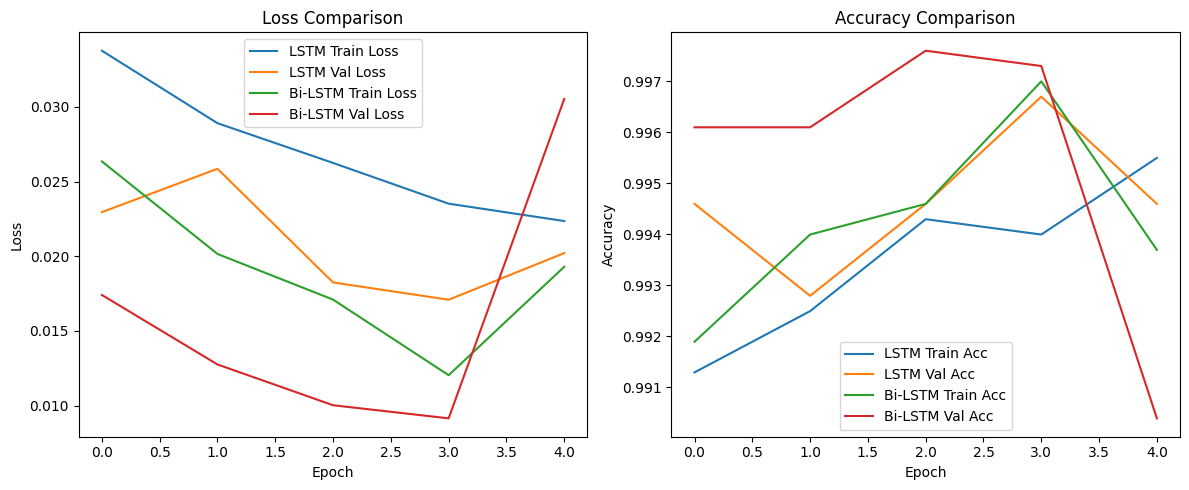


Test set performance comparison:
         Test Loss  Test Accuracy
LSTM      0.020213       0.994596
Bi-LSTM   0.030526       0.990393


In [76]:
# Call this function after training both models
plot_performance(history_lstm, history_bilstm)

# Evaluate both models on the test set and display in a table
def get_metrics(model, x_test, y_test):
    loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
    return {'Test Loss': loss, 'Test Accuracy': accuracy}

metrics_lstm = get_metrics(model1, x_test, y_test)
metrics_bilstm = get_metrics(model2, x_test, y_test)

df = pd.DataFrame([metrics_lstm, metrics_bilstm], index=['LSTM', 'Bi-LSTM'])
print("\nTest set performance comparison:")
print(df)